Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result.

In [1]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/Ignas12345/Project-in-Computational-Biology.git
!mv Project-in-Computational-Biology/* ./

Cloning into 'Project-in-Computational-Biology'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 79 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (79/79), 2.97 MiB | 6.13 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# Import libs

In [2]:
from models import *
from PIL import Image
from plotting import plot
from converters import turn_to_grayscale, image_to_tensor, tensor_to_image, generate_noise

import torch
import torch.optim
from models.downsampler import Downsampler

from utils.sr_utils import *

factor = 8 # 8

# Load image and baselines

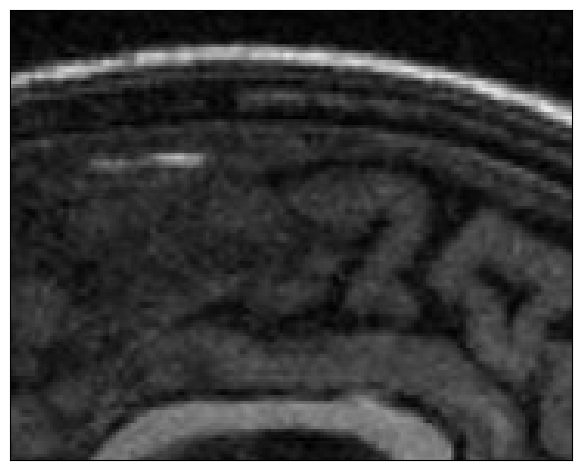

In [3]:
# Starts here
orig_img = Image.open('pictures/MRI_slice_zoomed_in.jpg')
plot([orig_img], cmap='gray')

In [39]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms import v2

def generate_noise(image, upscaling_factor, mean = 0, std_dev = 0.2):
  img_size = np.array(image).shape
  # next line taken from : https://stackoverflow.com/questions/1781970/multiplying-a-tuple-by-a-scalar
  img_size = tuple(i * upscaling_factor for i in img_size)
  noise = np.random.normal(mean, std_dev, img_size)
  #noise = (noise-np.min(noise))/(np.max(noise)-np.min(noise))
  return Image.fromarray(noise)

#this function turns an image to a tensor with values betwwen -1 and 1 (since edge net is trained for such tensors and I just followed their convention)
def image_to_tensor(image):
  tensor = v2.PILToTensor()(image)
  tensor = (2.0*tensor-(torch.min(tensor)+torch.max(tensor)))/(torch.max(tensor)-torch.min(tensor))
  #tensor = v2.Normalize([0.5], [0.5])(tensor)
  return tensor.unsqueeze(0)

#this function makes the tensor to be first in the range between 0 and 1 and then converts it to an image
def tensor_to_image(tensor):
  tensor = tensor.squeeze()
  tensor = (tensor + 1.0) / 2.0
  return v2.ToPILImage()(tensor)

def turn_to_grayscale(image):
  return v2.Grayscale()(image)

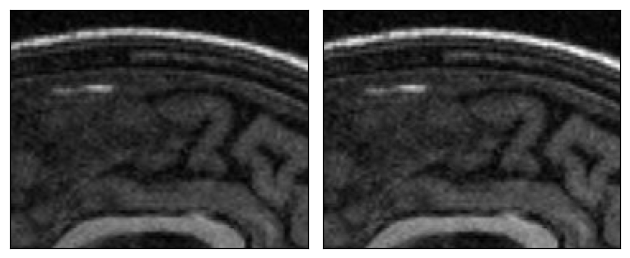

In [4]:
gray_img = turn_to_grayscale(orig_img)
plot([orig_img, gray_img], cmap='gray') #Since both are exactly the same, we will use the grayscale version for speed and less complexity

# Set up parameters and net

In [19]:
input_depth = 32

INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'

if factor == 4:
    num_iter = 2000
    reg_noise_std = 0.03
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
elif factor == 2:
    num_iter = 4000
    reg_noise_std = 0.05
else:
    assert False, 'We did not experiment with other factors'

In [6]:
net_image = generate_noise(gray_img, upscaling_factor = 8)

In [17]:
net_input = image_to_tensor(net_image)

In [20]:
NET_TYPE = 'skip' # UNet, ResNet
net = skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True)

# Losses
mse = torch.nn.MSELoss()

img_LR_var = image_to_tensor(gray_img)

downsampler = Downsampler(n_planes=1, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True)

In [21]:
torch.Tensor.size(img_LR_var)

torch.Size([1, 1, 145, 181])

# Define closure and optimize

In [22]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)
    total_loss.backward()
    print('iteration: ' + str(i))

    if i % 25 == 0:
      output_img = tensor_to_image(out_HR)
      plot([gray_img, output_img], cmap = 'gray')
      output_img.save('High_resolution_iteration_' + str(i) + '.jpg')

    i += 1

    return total_loss

Starting optimization with ADAM
iteration: 0


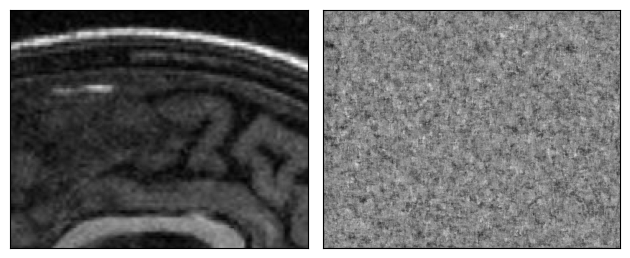

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25


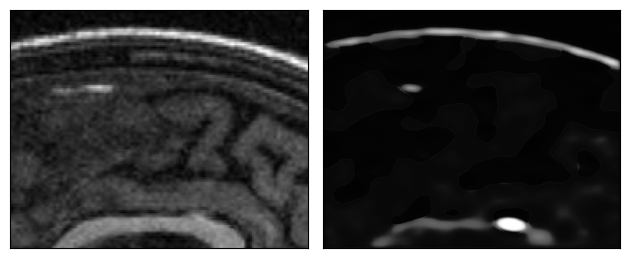

iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46


In [ ]:
psnr_history = []
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)

In [ ]:
out_HR_pil = np_to_pil(out_HR_np)

In [ ]:
plot_image_grid([out_HR_np], 4, 4);